# Deep Learning applied to Nodule Segmentation in Lung CT-scans

# Generate a mask to identify the lung region

In [1]:
!pwd

/home/mas/x110/DLToolboxImg


In [2]:
#!touch requirements.txt
#!pip freeze -r requirements.txt

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import pylidc as pl #pip install -Iv scikit-image==0.13
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import matplotlib.patches as patches
%matplotlib nbagg
import matplotlib.animation as animation
from IPython.display import HTML

In [32]:

import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import scipy.misc
import numpy as np
import random
random.seed(313)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys, os
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates



In [5]:
class ctscan():
    def __init__(self,scan_id):
        self.qu = pl.query(pl.Scan) #load data

        self.scan_id = scan_id

        self.scans = self.qu.all() 

        self.scan=self.scans[self.scan_id-1]

        self.slices= self.scan.load_all_dicom_images() #all raw slices of ctscan with metadata

        self.flag=0
    
    

        if len(self.slices)>1:
            for s in self.slices:
                try:
                  s.pixel_array
                except:
                  self.flag=-1
    
        if (self.flag==0 and len(self.slices)>1):
            self.image= np.stack([s.pixel_array for s in self.slices])
            self.image_HU=self.get_pixels_hu() #all slices of ctscan in Housenfield unit

            self.slice_thickness=self.slices[1].ImagePositionPatient[2]-self.slices[0].ImagePositionPatient[2]
            self.original_spacing = [self.scan.pixel_spacing,self.scan.pixel_spacing,
                                   self.slice_thickness]    
            self.desired_spacing = np.array([1,1,1])

            self.image_resampled,self.new_spacing=self.resample()
            self.image_normalized = self.normalize(self.image_resampled)

            self.z0=float(self.slices[0].ImagePositionPatient[2]) #they are sorted by pylidc #get initial z position

            self.anns= self.scan.annotations

            self.centroids1=self.allcentroids1()

            self.centroids2=self.allcentroids2()

            self.zarrs = [self.get_ann_z(ann) for ann in self.anns] #for each annotations get the z axis that it spans

            self.c2vsz=self.find_all_centroids()
            
            self.Zbbox=self.find_all_bbox()

            self.Z2=self.find_msk()


    def get_pixels_hu(self):
        image = self.image.astype(np.float32)
        image[image<-1000]=0
        for slice_number in range(len(self.slices)):
            intercept = self.slices[slice_number].RescaleIntercept
            slope = self.slices[slice_number].RescaleSlope
            image[slice_number] = slope * image[slice_number]
            image[slice_number] += intercept
        return np.array(image, dtype=np.int16) #zxy
  
    def resample(self):

        image=self.image_HU.copy() #zxy

        image=image.swapaxes(0,2) #yxz
        image=image.swapaxes(0,1) #xyz

        resize_factor = self.original_spacing/self.desired_spacing

        new_real_shape = image.shape * resize_factor

        new_shape = np.round(new_real_shape)

        real_resize_factor = new_shape/image.shape

        new_spacing = self.original_spacing/real_resize_factor

        image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

        image=image.swapaxes(0,2) #zyx
        image=image.swapaxes(1,2) #zxy

        return image, new_spacing


    def normalize(self,image):
        MIN_BOUND = -1000.0
        MAX_BOUND = 400.0

        image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
        image[image>1] = 1.
        image[image<0] = 0.
        return image

    def centroid1(self,ann): #convert centroid from mm into pixel location#centroid in coordinates1
        #find centroid
        row,col,depth =ann.centroid #row,col,z in original dimensions,m
        c=np.array([col,row,depth])
        #find centroid with z in slice thickness
        c1=c.copy().astype(int)
        #c1[2]=np.int((c[2]-self.z0)/self.slice_thickness)
        return c1

    def centroid2(self,c1): #convert into spacing of 1,1,1
        c2=c1*self.original_spacing
        c2=c2.astype(np.int)
        return c2

    def allcentroids1(self): #all nodule centroids in the original coordinate system
        centroids=[]
        for ann in self.anns:
            c1=self.centroid1(ann)
            centroids.append(c1)
        return centroids
    
    def allcentroids2(self): #all nodule centroids in the resampled coordinate system
        centroids=[]
        for c1 in self.centroids1:
            c2=self.centroid2(c1)
            centroids.append(c2)
        return centroids
    
    def bbox1(self,ann): #convert bbox from mm into pixel location
        #A=ann.bbox()
        #A[2]=(A[2]*1.0-self.z0)/self.slice_thickness
        A=ann.bbox_matrix() #yxz
        A=np.array([A[1],A[0],A[2]])
        return A
    
    def bbox2(self,ann): #convert into spacing of 1,1,1
        A1=self.bbox1(ann)
        A2=A1.T*self.original_spacing
        A2=A2.T
        return A2
    def get_ann_z(self,ann): #find the z that a nodule spans
        zs=[]
        A2=self.bbox2(ann)
        zarr=np.arange(A2[2][0],A2[2][1]+1).astype(np.int)
        return zarr

    #find centroid at each z location of the given volume
    def find_all_centroids(self):
        slices_num = self.image_resampled.shape[0]
        #initialize dict
        keys=np.arange(slices_num)
        Zc=dict() #The dict contains a mask for each z location
        [Zc.setdefault(key, []) for key in keys] #contains a centroid for each z

        for i,c2 in enumerate(self.centroids2):
            for key in self.zarrs[i]:
                Zc[key].append(c2[0:2])
        return Zc
    #find bottem left corner and dimension of bbox at each z location of the given volume
    def find_all_bbox(self):
        slices_num = self.image_resampled.shape[0]
        
        keys=np.arange(slices_num)
        Zxy=dict() #The dict contains a mask for each z location
        [Zxy.setdefault(key, []) for key in keys] #contains a centroid for each z
        
        for i,(ann,c2) in enumerate(zip(self.anns,self.centroids2)):
            A2=self.bbox2(ann)
            d1=A2.T[1]-A2.T[0]#bbox dim
            xy1=[c2[0]-d1[0]/2.,c2[1]-d1[1]/2.]
            for key in self.zarrs[i]:
                Zxy[key].append(xy1[0:2]+list(d1[0:2]))
        return Zxy
    def find_msk(self):
        msk = 0*self.image_resampled
        for ann in self.anns:
            x1,x2=np.floor(self.bbox2(ann)[0]).astype(np.int)
            y1,y2=np.floor(self.bbox2(ann)[1]).astype(np.int)
            z1,z2=np.floor(self.bbox2(ann)[2]).astype(np.int)
            msk[z1:z2+1,y1:y2+1,x1:x2+1]=1
        return msk

In [6]:
scan_id = 23
scan_1 = ctscan(scan_id)

Loading dicom files ... This may take a moment.


In [30]:
 
def get_segmented_lungs(im0,plot=False):
    im=im0.copy()
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -400
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im,binary

## take a volume of the scan and return a lung-mask volume
### return the binary mask
def get_segmented_lungs2(ims0, plot=False):
    Ss=[]
    Bs=[]
    for im0 in ims0: 
        S,B=get_segmented_lungs(im0, plot=False)
        Ss.append(S)
        Bs.append(B)
    Ss=np.array(Ss)
    Bs=np.array(Bs)
    return (Ss,Bs)


In [31]:
S,B=get_segmented_lungs2(scan_1.image_resampled, plot=False)


/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/mas/.virtualenvs/colab/lib/python3.5/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


In [66]:
len(ind)

20

<IPython.core.display.Javascript object>


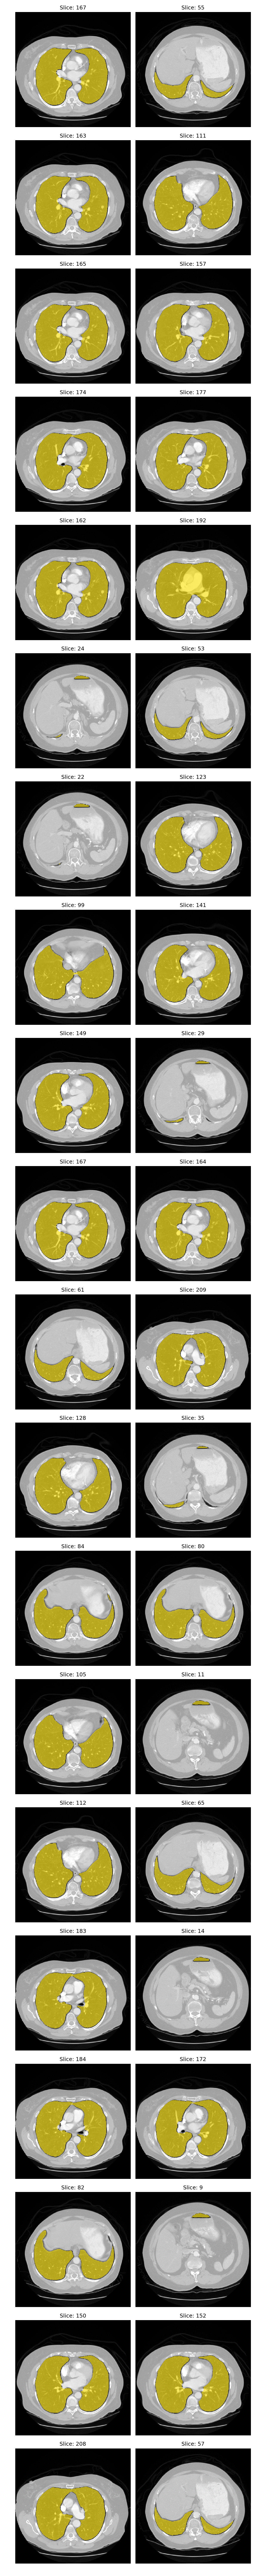

In [69]:
zs=40

ind0 =[k for k,v in scan_1.c2vsz.items() if v!=[]]
ind = np.random.randint(ind0[-1],size=zs)

Z2=B.copy()
Z2 = np.ma.masked_where(Z2 ==0 , Z2)

num_rows=20
num_cols=2

f, plots = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(8, 80))


for i in range(zs):
    ii=ind[i]
    plots[i // num_cols, i % num_cols].axis('off')
    plots[i // num_cols, i % num_cols].imshow(scan_1.image_normalized[ii],'gray',vmin=0,vmax=1)

    plots[i // num_cols, i % num_cols].imshow(Z2[ii],alpha=0.7,vmin=0,vmax=1)
    plots[i // num_cols, i % num_cols].set_title("Slice: "+str(ii))
      
plt.tight_layout()